In [1]:
import numpy as np
import pandas as pd
import skyfield
from skyfield.api import load
from skyfield.positionlib import ICRF, Barycentric
import astropy
from astropy.units import deg, au, km, meter, day, minute, second
from astropy.coordinates import SkyCoord, GCRS, BarycentricMeanEcliptic, HeliocentricMeanEcliptic
import matplotlib.pyplot as plt

# MSE imports
import astro_utils
from astro_utils import jd_to_mjd, radec2dir, radec_diff, qv2radec, qvrel2radec

In [2]:
light_speed = astropy.constants.c.to(au / minute)
light_speed

<Quantity 0.12023933 AU / min>

### Observation of Earth and Mars according to JPL

In [3]:
# Load the JPL position of Earth as CSV
df_earth = pd.read_csv('../data/jpl/testing/vectors-earth.txt', index_col=False)

# Display the dataframe
df_earth

,JulianDate,CalendarDate,X,Y,Z,VX,VY,VZ,LT,RG,RR
0,2455197.5,A.D. 2010-Jan-01 00:00:00.0000,-0.179765,0.970347,-0.000017,-0.017202,-0.003148,8.961125e-07,0.005700,0.986858,0.000038
1,2455198.5,A.D. 2010-Jan-02 00:00:00.0000,-0.196939,0.967049,-0.000017,-0.017145,-0.003447,9.036109e-07,0.005700,0.986899,0.000044
2,2455199.5,A.D. 2010-Jan-03 00:00:00.0000,-0.214053,0.963453,-0.000016,-0.017083,-0.003745,8.653246e-07,0.005700,0.986945,0.000049
3,2455200.5,A.D. 2010-Jan-04 00:00:00.0000,-0.231103,0.959559,-0.000015,-0.017017,-0.004042,7.855759e-07,0.005700,0.986997,0.000054
4,2455201.5,A.D. 2010-Jan-05 00:00:00.0000,-0.248085,0.955369,-0.000014,-0.016945,-0.004339,6.725245e-07,0.005701,0.987054,0.000059
...,...,...,...,...,...,...,...,...,...,...,...
3648,2458845.5,A.D. 2019-Dec-28 00:00:00.0000,-0.100787,0.986067,-0.000022,-0.017416,-0.001767,9.809367e-07,0.005725,0.991204,0.000013
3649,2458846.5,A.D. 2019-Dec-29 00:00:00.0000,-0.118187,0.984147,-0.000021,-0.017382,-0.002073,9.327289e-07,0.005725,0.991218,0.000015
3650,2458847.5,A.D. 2019-Dec-30 00:00:00.0000,-0.135550,0.981922,-0.000020,-0.017343,-0.002377,8.590659e-07,0.005725,0.991234,0.000017
3651,2458848.5,A.D. 2019-Dec-31 00:00:00.0000,-0.152871,0.979393,-0.000019,-0.017298,-0.002681,7.650397e-07,0.005725,0.991251,0.000019


In [4]:
# Load the JPL position of Mars as CSV
df_mars = pd.read_csv('../data/jpl/testing/vectors-mars.txt', index_col=False)

# Display the dataframe
df_mars

,JulianDate,CalendarDate,X,Y,Z,VX,VY,VZ,LT,RG,RR
0,2455197.5,A.D. 2010-Jan-01 00:00:00.0000,-0.733418,1.457212,0.048394,-0.011980,-0.005093,0.000188,0.009426,1.632088,0.000842
1,2455198.5,A.D. 2010-Jan-02 00:00:00.0000,-0.745374,1.452070,0.048580,-0.011930,-0.005192,0.000184,0.009431,1.632927,0.000834
2,2455199.5,A.D. 2010-Jan-03 00:00:00.0000,-0.757278,1.446828,0.048763,-0.011879,-0.005291,0.000181,0.009436,1.633756,0.000826
3,2455200.5,A.D. 2010-Jan-04 00:00:00.0000,-0.769131,1.441488,0.048942,-0.011827,-0.005390,0.000178,0.009441,1.634578,0.000817
4,2455201.5,A.D. 2010-Jan-05 00:00:00.0000,-0.780931,1.436049,0.049118,-0.011774,-0.005488,0.000174,0.009445,1.635391,0.000809
...,...,...,...,...,...,...,...,...,...,...,...
3648,2458845.5,A.D. 2019-Dec-28 00:00:00.0000,-1.356374,-0.836106,0.015533,0.007920,-0.010678,-0.000418,0.009203,1.593445,-0.001143
3649,2458846.5,A.D. 2019-Dec-29 00:00:00.0000,-1.348404,-0.846754,0.015114,0.008019,-0.010616,-0.000419,0.009196,1.592299,-0.001149
3650,2458847.5,A.D. 2019-Dec-30 00:00:00.0000,-1.340336,-0.857339,0.014695,0.008117,-0.010553,-0.000420,0.009190,1.591146,-0.001155
3651,2458848.5,A.D. 2019-Dec-31 00:00:00.0000,-1.332170,-0.867860,0.014274,0.008215,-0.010490,-0.000421,0.009183,1.589988,-0.001161


In [5]:
# Load the JPL RA and DEC for Mars as fixed width file
df_obs = pd.read_fwf('../data/jpl/testing/observe-mars-earth-geocenter.txt')

# Display the dataframe
df_obs

,Date,Time,JulianDate,RA,DEC,RA_apparent,DEC_apparent delta,delta_dot,light_time
0,2010-Jan-01,00:00,2455197.5,142.327061,18.799029,142.475968,18.752303941 0.73883173669463,-8.970408,6.144676
1,2010-Jan-02,00:00,2455198.5,142.179197,18.888379,142.328371,18.841710905 0.73372184383589,-8.724067,6.102178
2,2010-Jan-03,00:00,2455199.5,142.017468,18.981461,142.166897,18.934867206 0.72875633894059,-8.470333,6.060882
3,2010-Jan-04,00:00,2455200.5,141.841890,19.078173,141.991560,19.031670832 0.72393956594361,-8.208951,6.020822
4,2010-Jan-05,00:00,2455201.5,141.652504,19.178403,141.802402,19.132004243 0.71927600922442,-7.939695,5.982036
...,...,...,...,...,...,...,...,...,...
3648,2019-Dec-28,00:00,2458845.5,233.190100,-18.727810,233.467326,-18.791714023 2.21286843425630,-12.191696,18.403866
3649,2019-Dec-29,00:00,2458846.5,233.876730,-18.895847,234.154585,-18.958738129 2.20580870839279,-12.255895,18.345152
3650,2019-Dec-30,00:00,2458847.5,234.565048,-19.061459,234.843518,-19.123323188 2.19871232427735,-12.318649,18.286133
3651,2019-Dec-31,00:00,2458848.5,235.255049,-19.224614,235.534120,-19.285436340 2.19158011449378,-12.379967,18.226816


In [6]:
# Extract position and velocity of earth from df_earth
q_earth_jpl = np.array([df_earth.X.values, df_earth.Y.values, df_earth.Z.values]) * au
v_earth_jpl = np.array([df_earth.VX.values, df_earth.VY.values, df_earth.VZ.values]) * au / day

# Extract position of mars from df_mars
q_mars_jpl = np.array([df_mars.X.values, df_mars.Y.values, df_mars.Z.values]) * au
v_mars_jpl = np.array([df_mars.VX.values, df_mars.VY.values, df_mars.VZ.values]) * au / day

# Extract obstime_jd, ra, and dec from DataFrame
obstime_jd = df_obs.JulianDate.values
ra_jpl = df_obs.RA.values
dec_jpl = df_obs.DEC.values

# Vector of observation times in MJD format
obstime_mjd = jd_to_mjd(obstime_jd)

### Position & Observation of Earth and Mars according to Skyfield

In [7]:
# Manually load planetary positions using de435
planets_sf = load('../data/jpl/ephemeris/de435.bsp')
earth_sf = planets_sf['earth']
mars_sf = planets_sf['mars barycenter']

# load timescale
ts = load.timescale()

# Generate vector of observation times in Skyfield format
obstime_sf = ts.tt_jd(obstime_jd)

In [8]:
# Observe mars from earth with Skyfield
obs_sf = earth_sf.at(obstime_sf).observe(mars_sf)

# Build Skyfield angle arrays (RA, DEC) and distance array (delta)
ra_sf_aa, dec_sf_aa, delta_sf_da = obs_sf.radec()

# Extract degrees and AU to get plain arrays
ra_sf = ra_sf_aa._degrees
dec_sf = dec_sf_aa._degrees
delta_sf = delta_sf_da.au

In [9]:
# Load planetary positions and velocities by querying the Skyfield JPL ephemeris interface
# Create them as arrays with bundled astropy units of au and km / second

# Earth
q_earth_sf = earth_sf.at(obstime_sf).ecliptic_position().au * au
v_earth_sf = earth_sf.at(obstime_sf).ecliptic_velocity().km_per_s * km / second

# Mars
q_mars_sf = mars_sf.at(obstime_sf).ecliptic_position().au * au
v_mars_sf = mars_sf.at(obstime_sf).ecliptic_velocity().km_per_s * km / second

In [10]:
# Demonstrate that q_earth_sf is the same as q_earth_jpl
q_earth_eps = np.mean(np.linalg.norm(q_earth_sf - q_earth_jpl, axis=0))
v_earth_eps = np.mean(np.linalg.norm(v_earth_sf - v_earth_jpl, axis=0))
q_mars_eps = np.mean(np.linalg.norm(q_mars_sf - q_mars_jpl, axis=0))
v_mars_eps = np.mean(np.linalg.norm(v_mars_sf - v_mars_jpl, axis=0))

# Report
print('Difference between Skyfield (JPL ephem) and Horizons download:')
print(f'q_earth : {q_earth_eps:5.3e} au')
print(f'v_earth : {v_earth_eps:5.3e} au / day')
print(f'q_mars  : {q_mars_eps:5.3e} au')
print(f'v_mars  : {v_mars_eps:5.3e} au / day')

Difference between Skyfield (JPL ephem) and Horizons download:
q_earth : 1.406e-09 au
v_earth : 1.626e-08 au / day
q_mars  : 1.565e-09 au
v_mars  : 3.758e-08 au / day


In [11]:
# Alias q_earth, v_earth, q_mars, v_mars to the Skyfield interpolation for legibility
q_earth = q_earth_sf
v_earth = v_earth_sf
q_mars = q_mars_sf
v_mars = v_mars_sf

### Compare Skyfield vs JPL

In [12]:
# Compute difference in angles
diff_sf = radec_diff('JPL', 'Skyfield', ra1=ra_jpl, dec1=dec_jpl, ra2=ra_sf, dec2=dec_sf, 
                     obstime_mjd=obstime_mjd, verbose=False)
diff_mean = np.mean(diff_sf)
diff_median = np.median(diff_sf)

# Report results
print(f'Mean Angle Difference: JPL vs. Skyfield')
print(f'Mean  : {diff_mean:5.3f} seconds')
print(f'Median: {diff_median:5.3f} seconds')

Mean Angle Difference: JPL vs. Skyfield
Mean  : 1.598 seconds
Median: 1.822 seconds


In [13]:
# Day with biggest error
idx = np.argmax(diff_sf)
print(f'Date with largest error:')
print(f'index    = {idx}')
print(f'MJD      = {obstime_mjd[idx]}')
print(f'Date     = {astro_utils.mjd_to_date(obstime_mjd[idx])}')
print()
print(f'ra_sf    = {ra_sf[idx]:10.6f}')
print(f'ra_jpl   = {ra_jpl[idx]:10.6f}')
print(f'ra diff  = {ra_sf[idx]-ra_jpl[idx]:10.6f}')
print()
print(f'dec_sf   = {dec_sf[idx]:10.6f}')
print(f'dec_jpl  = {dec_jpl[idx]:10.6f}')
print(f'dec diff = {dec_sf[idx]-dec_jpl[idx]:10.6f}')
print()
print(f'AngleDiff= {diff_sf[idx]:7.3f}    seconds')

Date with largest error:
index    = 1121
MJD      = 56318.0
Date     = 2013-01-26

ra_sf    = 326.894343
ra_jpl   = 326.894940
ra diff  =  -0.000597

dec_sf   = -14.453341
dec_jpl  = -14.453133
dec diff =  -0.000208

AngleDiff=   2.213    seconds


### Observation of Mars Using MSE Function qv2radec and Skyfield Positions

In [14]:
# Calculate light time from mars to earth
dist_e2m = np.linalg.norm(q_mars - q_earth, axis=0)* au
light_time = dist_e2m / light_speed

# Adjustment of mars position for light time
dq_mars_lt = v_mars.to(au / minute) * light_time

In [15]:
# Use simple function that accepts only the position and velocity of the observed body
ra_mse1, dec_mse1, r_mse1 = qv2radec(q=q_mars, v=v_mars, mjd=obstime_mjd, frame=BarycentricMeanEcliptic)

In [16]:
# Compute difference in angles
diff_mse1 = radec_diff('JPL', 'MSE', ra1=ra_jpl, dec1=dec_jpl, ra2=ra_mse1, dec2=dec_mse1, 
                     obstime_mjd=obstime_mjd, verbose=False)
diff_mean = np.mean(diff_mse1)
diff_median = np.median(diff_mse1)

# Report results
print(f'Mean Angle Difference: JPL vs. MSE qv2radec')
print(f'Mean  : {diff_mean:5.3f} seconds')
print(f'Median: {diff_median:5.3f} seconds')

Mean Angle Difference: JPL vs. MSE qv2radec
Mean  : 8.780 seconds
Median: 4.414 seconds


In [17]:
# Day with biggest error
idx = np.argmax(diff_mse1)
print(f'Date with largest error:')
print(f'index    = {idx}')
print(f'MJD      = {obstime_mjd[idx]}')
print(f'Date     = {astro_utils.mjd_to_date(obstime_mjd[idx])}')
print()
print('q_earth   = ', q_earth[:, idx])
print('q_mars    = ', q_mars[:, idx])
print()
print(f'ra_mse1  = {ra_mse1[idx]:10.6f}')
print(f'ra_jpl   = {ra_jpl[idx]:10.6f}')
print(f'ra diff  = {ra_mse1[idx]-ra_jpl[idx]:10.6f}')
print()
print(f'dec_mse1 = {dec_mse1[idx]:10.6f}')
print(f'dec_jpl  = {dec_jpl[idx]:10.6f}')
print(f'dec diff = {dec_mse1[idx]-dec_jpl[idx]:10.6f}')
print()
print(f'AngleDiff= {diff_mse1[idx]:7.3f}    seconds')

Date with largest error:
index    = 29
MJD      = 55226.0
Date     = 2010-01-30

q_earth   =  [-6.34839522e-01  7.59128133e-01 -8.23207648e-06] AU
q_mars    =  [-1.05691175  1.26972101  0.05241258] AU

ra_mse1  = 133.322941
ra_jpl   = 133.313417
ra diff  =   0.009524

dec_mse1 =  22.209082
dec_jpl  =  22.211609
dec diff =  -0.002527

AngleDiff=  33.022    seconds


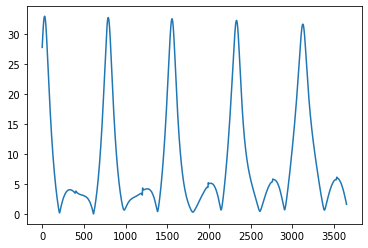

In [18]:
_ = plt.plot(diff_mse1)
plt.show()

### Observation of Mars Using MSE Function qvrel2radec and Skyfield Positions

In [19]:
# Use advanced function that  accepts position and velocity of body and earth
ra_mse2, dec_mse2, r_mse2 = qvrel2radec(q_body=q_mars, v_body=v_mars, 
                                        q_earth=q_earth, v_earth=v_earth,
                                        mjd=obstime_mjd, frame=BarycentricMeanEcliptic)

In [26]:
# Compute difference in angles
diff_mse2 = radec_diff('JPL', 'MSE', ra1=ra_jpl, dec1=dec_jpl, ra2=ra_mse2, dec2=dec_mse2, 
                     obstime_mjd=obstime_mjd, verbose=False)
diff_mean = np.mean(diff_mse2)
diff_median = np.median(diff_mse2)

# Report results
print(f'Mean Angle Difference: JPL vs. MSE qvrel2radec')
print(f'Mean  : {diff_mean:5.3f} seconds')
print(f'Median: {diff_median:5.3f} seconds')

Mean Angle Difference: JPL vs. MSE qvrel2radec
Mean  : 9.778 seconds
Median: 5.223 seconds
